# 🔄 Agent Workflows with Microsoft Agent Framework (Python)

## 📋 What You'll Learn

This notebook shows you how to create multi-agent workflows where multiple AI agents work together in sequence. You'll build a simple travel recommendation workflow with two agents: a front desk agent and a reviewer agent.

**What's Inside:**
- 🏗️ **Workflow Builder**: Chain multiple agents together
- 📊 **Workflow Visualization**: See your workflow as a diagram
- 🔄 **Event-Driven Execution**: Process workflow results step by step
- 🤝 **Multi-Agent Coordination**: Agents reviewing each other's work

## ⚙️ Setup Requirements

### 1. **Docker & Dev Container**
- Install Docker on your machine
- Open this project in the dev container (VS Code will prompt you)

### 2. **Workspace Configuration**
- Open the workspace: `File > Open Workspace from File` → select `workspace.code-workspace`
- This sets up the correct Python environment for each project folder

### 3. **Environment Variables**
1. Copy `.env.example` to `.env` in the `agent-framework-samples` folder:
   ```bash
   cp .env.example .env
   ```
2. Fill in your Azure credentials:
   ```env
   # Azure OpenAI (Required for this example)
   AZURE_OPENAI_ENDPOINT=your_endpoint
   AZURE_OPENAI_CHAT_DEPLOYMENT_NAME=your_deployment
   ```

### 4. **System Dependencies**
The notebook will install graphviz automatically for workflow visualization.

## 🚀 What You'll Build

A simple workflow with two agents:

```
User Request → Front Desk Agent → Reviewer Agent → Final Response
```

1. **Front Desk Agent**: Provides travel recommendations
2. **Reviewer Agent**: Reviews and validates the recommendations

You'll see:
- How to define agent instructions
- How to connect agents in a workflow
- How to visualize the workflow structure
- How to run the workflow and process results

Let's build a collaborative agent workflow! 🌟

In [ ]:
! sudo apt update 
! sudo apt install graphviz -y

Hit:1 http://deb.debian.org/debian bookworm InRelease
Hit:2 http://deb.debian.org/debian bookworm-updates InRelease                  
Hit:3 http://deb.debian.org/debian-security bookworm-security InRelease        
Hit:4 https://dl.yarnpkg.com/debian stable InRelease                           
Hit:5 https://packages.microsoft.com/repos/azure-cli bookworm InRelease        
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
All packages are up to date.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-7+deb12u1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [2]:
! pip install agent-framework-core -U
! pip install agent-framework[viz] -U
! pip install graphviz -U

In [ ]:
# 🔄 Import Workflow and Agent Framework Components
# Core components for building sophisticated agent workflows

from agent_framework.openai import OpenAIChatClient    # 🤖 GitHub Models client integration
from agent_framework import WorkflowBuilder, WorkflowEvent, WorkflowViz  # 🏗️ Workflow orchestration tools
from dotenv import load_dotenv  
from agent_framework import ChatAgent
from azure.identity import AzureCliCredential, DefaultAzureCredential
from agent_framework.azure import AzureOpenAIChatClient
from agent_framework.openai import OpenAIChatClient
import os                      # 🔧 Environment variable access
from azure.ai.projects.aio import AIProjectClient
from agent_framework.azure import AzureAIAgentClient
load_dotenv()

True

In [ ]:
# Step 1: Define agent instructions (what each agent should do)

# Reviewer agent: checks if recommendations are authentic and local
REVIEWER_NAME = "Concierge"
REVIEWER_INSTRUCTIONS = """
    You are an are hotel concierge who has opinions about providing the most local and authentic experiences for travelers.
    The goal is to determine if the front desk travel agent has recommended the best non-touristy experience for a traveler.
    If so, state that it is approved.
    If not, provide insight on how to refine the recommendation without using a specific example. 
    """

# Front desk agent: provides travel recommendations    
FRONTDESK_NAME = "FrontDesk"
FRONTDESK_INSTRUCTIONS = """
    You are a Front Desk Travel Agent with ten years of experience and are known for brevity as you deal with many customers.
    The goal is to provide the best activities and locations for a traveler to visit.
    Only provide a single recommendation per response.
    You're laser focused on the goal at hand.
    Don't waste time with chit chat.
    Consider suggestions when refining an idea.
    """

# Step 2: Create the Azure OpenAI client
chat_client = AzureOpenAIChatClient(credential=DefaultAzureCredential())

# Step 3: Create both agents using the client and instructions
reviewer_agent = chat_client.create_agent(
    instructions=REVIEWER_INSTRUCTIONS,
    name=REVIEWER_NAME,
)

front_desk_agent = chat_client.create_agent(
    instructions=FRONTDESK_INSTRUCTIONS,
    name=FRONTDESK_NAME,
)

Generating workflow visualization...
Mermaid string: 
flowchart TD
  FrontDesk["FrontDesk (Start)"];
  Concierge["Concierge"];
  FrontDesk --> Concierge;
DiGraph string: 
digraph Workflow {
  rankdir=TD;
  node [shape=box, style=filled, fillcolor=lightblue];
  edge [color=black, arrowhead=vee];

  "FrontDesk" [fillcolor=lightgreen, label="FrontDesk\n(Start)"];
  "Concierge" [label="Concierge"];
  "FrontDesk" -> "Concierge";
}
SVG file saved to: /tmp/tmpiji96jxv.svg
Attempting to display SVG file at: /tmp/tmpiji96jxv.svg


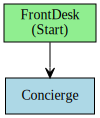


🎯 Running workflow with request: 'I would like to go to Paris.'

✅ Final workflow result:
Visit the Eiffel Tower for stunning views of the city.I appreciate your enthusiasm for the Eiffel Tower; however, it is one of the most tourist-heavy attractions in Paris. To ensure your experience is more authentic and representative of local culture, consider exploring neighborhoods where Parisians spend their day-to-day lives, immersing yourself in unique markets, or dining places where locals frequent. Aim to engage in experiences that reflect the lifestyle and rhythm of the city outside of landmark hotspots. Let me know if you’d like further tips!

✅ Final workflow result:
Visit the Eiffel Tower for stunning views of the city.I appreciate your enthusiasm for the Eiffel Tower; however, it is one of the most tourist-heavy attractions in Paris. To ensure your experience is more authentic and representative of local culture, consider exploring neighborhoods where Parisians spend their day-to-day

In [15]:
# Step 4: Build and visualize the workflow

from IPython.display import SVG, display, HTML
import os

# Define a custom event type for our workflow
class DatabaseEvent(WorkflowEvent): ...

# Build the workflow: front_desk_agent → reviewer_agent
workflow = (WorkflowBuilder()
    .set_start_executor(front_desk_agent)  # Start with front desk agent
    .add_edge(front_desk_agent, reviewer_agent)  # Then go to reviewer agent
    .build())

# Visualize the workflow structure
print("Generating workflow visualization...")
viz = WorkflowViz(workflow)

# Print workflow in different formats
print("Mermaid string: \n=======")
print(viz.to_mermaid())  # Mermaid diagram format
print("=======")

print("DiGraph string: \n=======")
print(viz.to_digraph())  # Graph format
print("=======")

# Export as SVG image
svg_file = viz.export(format="svg")
print(f"SVG file saved to: {svg_file}")

# Try to display the SVG in the notebook
print(f"Attempting to display SVG file at: {svg_file}")

if svg_file and os.path.exists(svg_file):
    try:
        # Try direct SVG rendering
        display(SVG(filename=svg_file))
    except Exception as e:
        print(f"⚠️ Direct SVG render failed: {e}. Falling back to raw HTML.")
        try:
            # Fallback to HTML rendering
            with open(svg_file, "r", encoding="utf-8") as f:
                svg_text = f.read()
            display(HTML(svg_text))
        except Exception as inner:
            print(f"❌ Fallback HTML render also failed: {inner}")
else:
    print("❌ SVG file not found. Ensure viz.export(format='svg') ran successfully.")

# Step 5: Run the workflow with a travel request
print("\n🎯 Running workflow with request: 'I would like to go to Paris.'")
result = ''

async for event in workflow.run_stream('I would like to go to Paris.'):
    # Collect workflow output from events
    if isinstance(event, DatabaseEvent):
        print(f"{event}")
    if isinstance(event, WorkflowEvent):
        result += str(event.data)
        
# Clean up and display final result
result = result.replace("None", "")
print("\n✅ Final workflow result:")
print(result)